In [2]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter
import pickle


! pip install hiddenlayer
import hiddenlayer as hl
import hiddenlayer.transforms as ht
from torch.autograd import Variable
from pdb import set_trace

import scipy.io

In [3]:
!pip install torchviz

In [4]:
from torchviz import make_dot, make_dot_from_trace

In [6]:
!git clone https://github.com/Huawei-Sirius-Summer-2020/DPDBlocks.git

fatal: destination path 'DPDBlocks' already exists and is not an empty directory.


In [7]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [8]:
!git clone https://github.com/Huawei-Sirius-Summer-2020/BlackBoxData.git

fatal: destination path 'BlackBoxData' already exists and is not an empty directory.


In [21]:
cd /content/BlackBoxData


/content/BlackBoxData


In [9]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

In [10]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [11]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [12]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()

In [13]:
def eval_model(valid_queue, model, criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        out = model.forward(input_batch)


        loss=criterion(out,desired)
        plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
        plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
        plt.show()

        
        accuracy = NMSE(input_batch, out-desired)
#         print('Loss = ',loss.cpu().detach().numpy(), 'Accuracy = ', accuracy.cpu().detach().numpy(), 'dbs')
    return loss,accuracy
#     return model

In [14]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment='/content/drive/My Drive/Colab Notebooks/huawei/new_folder'):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')
    return hist

In [15]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

In [16]:
np.random.seed()
# torch.cuda.set_device()
cudnn.benchmark = True
torch.manual_seed(10)
cudnn.enabled=True
torch.cuda.manual_seed(10)

In [17]:
Batch_size=5000

In [18]:
gamma=0.95
step_size=5

In [22]:
name = 'BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']

x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
print(x_real.shape)

X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

torch.Size([99840, 1])


In [23]:
loss_fn = nn.MSELoss()

In [26]:
class Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

In [17]:
class Sasha_Cell_apd(nn.Module):
    def __init__(self,M=15,D1=0,D2=0,Poly_order=8,Passthrough=False):
        super(Sasha_Cell_apd,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,1)
        self.f3=AFIR(M,0)
        self.f4=AFIR(M,1)
        self.pol1=Polynomial(Poly_order,True) # было Passthrough
        self.pol2=Polynomial(Poly_order,True) # было Passthrough
        self.delay1=Delay(D1)
        self.delay2=Delay(D2)
        self.prod=Prod_cmp()
    def forward(self,x):
        x1 = x.clone()
        x2 = x.clone()
        x1=self.delay1(x1)
        x2=self.delay2(x2)
        lis = self.f1(self.pol1(x1)) + self.f2(x1)
        sah = self.f3(self.pol2(x2)) + self.f4(x2)
        return self.prod(lis, sah)

In [18]:
class Olga_Cell(nn.Module):
    def __init__(self,M=15,D=2,Poly_order=2,Passthrough=True):
        super(Olga_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,3)
        self.f3=AFIR(M,4)
        self.delay=Delay(D)
        self.pol_smal=Polynomial(2,Passthrough)
        self.pol_big=Polynomial(10,Passthrough)
        self.prod=Prod_cmp()
 
    def forward(self,x):
        source = x.clone()
        x=self.delay(x)
        up=self.f1(x) 
 
        mid = self.pol_smal(source)
        mid = self.prod(source,mid)
        mid = self.f2(mid)
 
        low = self.pol_big(source)
        low = self.prod(low, source)
        low = self.f3(low)
        return up+mid+low

In [30]:
class Olga_Better_Cell(nn.Module):
    def __init__(self,M=15,D1=-1,D2=0,D3=1,Poly_order=2,Passthrough=True):
        super(Olga_Better_Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,3)
        self.f3=AFIR(M,4)
        self.delay1=Delay(D1)
        self.delay2=Delay(D2)
        self.delay3=Delay(D3)
        self.pol_smal=Polynomial(2,Passthrough)
        self.pol_big=Polynomial(10,Passthrough)
        self.prod=Prod_cmp()
 
    def forward(self,x):
        source = x.clone()
        up=self.delay1(x)
        up=self.f1(up) 
 
        mid = self.delay2(x)
        mid = self.pol_smal(mid)
        mid = self.prod(source,mid)
        mid = self.f2(mid)
 
        low = self.delay3(x)
        low = self.pol_big(low)
        low = self.prod(low, source)
        low = self.f3(low)
        return up+mid+low

In [19]:
const1 = 5
const2 = -2
const3 = -1
const4 = 3
const5 = 4
const6 = 4
const7 = -7
const8 = 7
const9 = 0
const10 = -3
const11 = 5
const12 = 2
const13 = -3
const14 = -1

In [ ]:
net = Cell(D=0)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)
print(hist)
##draw blocks
hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)


In [21]:
torch.cuda.is_available()

True

/content/DPDBlocks/blocks.py:38: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]] if self.M>0 else self.op(x)[:,:,-x.shape[2]:]


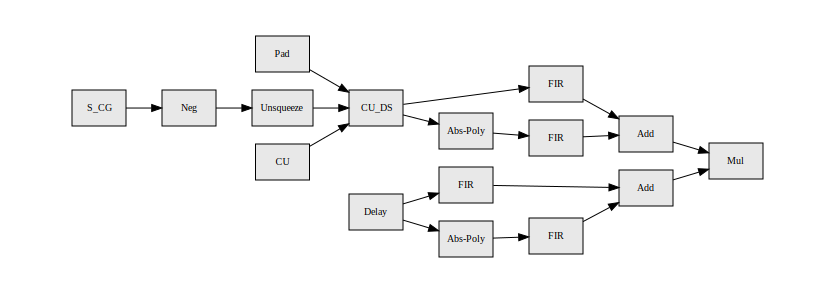

In [22]:
net = Sasha_Cell_apd(D1=const1, D2=const2)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist1 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

In [ ]:
net = Sasha_Cell_apd(D1=const3, D2=const4)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist2 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
net = Sasha_Cell_apd(D1=const5, D2=const6)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist3 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)


/content/DPDBlocks/blocks.py:38: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]] if self.M>0 else self.op(x)[:,:,-x.shape[2]:]


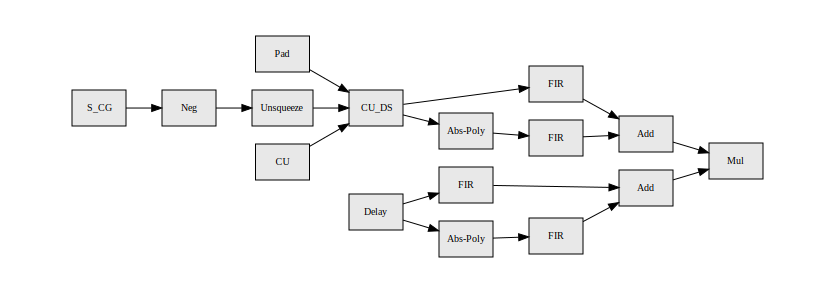

In [23]:
net = Sasha_Cell_apd(D1=const7, D2=const8)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist4 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

/content/DPDBlocks/blocks.py:38: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]] if self.M>0 else self.op(x)[:,:,-x.shape[2]:]


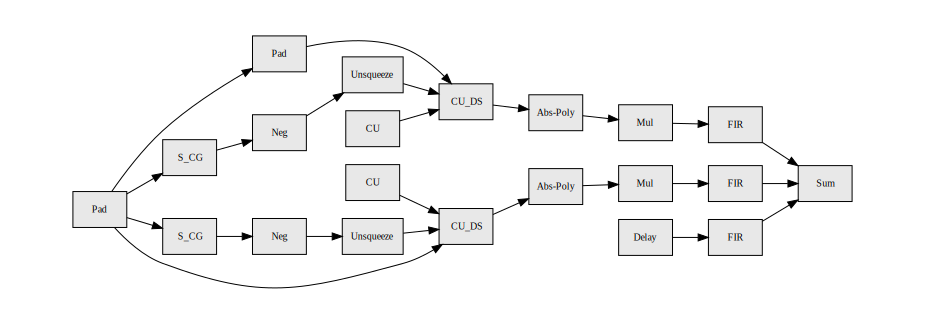

In [31]:
net = Olga_Better_Cell(D1=1, D2=0, D3=-1)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
net = Sasha_Cell_apd(D1=const9, D2=const10)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist5 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

In [ ]:
net = Sasha_Cell_apd(D1=const11, D2=const12)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist6 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

In [ ]:
net = Sasha_Cell_apd(D1=const13, D2=const14)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist7 = train(train_queue, valid_queue, net, loss_fn, optimizer,30,scheduler,save_flag=False)

In [ ]:
def Comparison_results(hist1, hist2, number, const1, const2):
    print("number =", number, "   delays:", const1, const2)
    fig, ax = plt.subplots()
    ax.plot(hist1['iter'], hist1['train_loss_db'], label='Maslovski')
    ax.plot(hist2['iter'], hist2['train_loss_db'], label='Bred')
    ax.set_xlabel('iter')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of two types of cells: iter')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(hist1['time'], hist1['train_loss_db'], label='Maslovski')
    ax.plot(hist2['time'], hist2['train_loss_db'], label='Bred')
    ax.set_xlabel('time')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of two types of cells: time')
    ax.legend()
    plt.show()

    


In [ ]:
def Comparison_best_res(hist1, hist2, hist3):
    #print("M_delays =", m)
    #print("Br_delays =", b1, b2)
    #print("Ol_delays =", ol)
    fig, ax = plt.subplots()
    ax.plot(hist1['iter'], hist1['train_loss_db'], label='Ol_v1')
    ax.plot(hist2['iter'], hist2['train_loss_db'], label='Masl_poly10')
    ax.plot(hist3['iter'], hist3['train_loss_db'], label='Masl_upd')
    ax.set_xlabel('iter')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of three types of cells: iter')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(hist1['time'], hist1['train_loss_db'], label='Ol_v1')
    ax.plot(hist2['time'], hist2['train_loss_db'], label='Masl_poly10')
    ax.plot(hist3['time'], hist3['train_loss_db'], label='Masl_upd')
    ax.set_xlabel('time')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of three types of cells: time')
    ax.legend()
    plt.show()

In [ ]:
Comparison_results(hist, hist1, 1, const1, const2)

In [ ]:
Comparison_results(hist, hist2, 2, const3, const4)

In [ ]:
Comparison_results(hist, hist3, 3, const5, const6)

In [ ]:
Comparison_results(hist, hist4, 4, const7, const8)

In [ ]:
Comparison_results(hist, hist5, 5, const9, const10)

In [ ]:
Comparison_results(hist, hist6, 6, const11, const12)

In [ ]:
Comparison_results(hist, hist7, 7, const13, const14)

In [ ]:
net = Sasha_Cell_apd(D1=const3, D2=const4)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist9 = train(train_queue, valid_queue, net, loss_fn, optimizer,80,scheduler,save_flag=False)

/content/DPDBlocks/blocks.py:38: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]] if self.M>0 else self.op(x)[:,:,-x.shape[2]:]


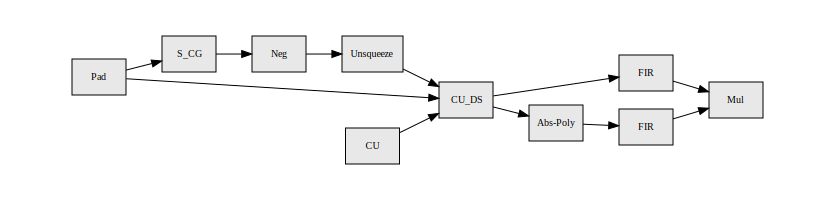

In [27]:
net = Cell(D=0)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

/content/DPDBlocks/blocks.py:38: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]] if self.M>0 else self.op(x)[:,:,-x.shape[2]:]


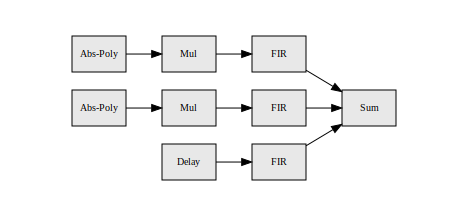

In [24]:
net = Olga_Cell(D=2)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist10 = train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
Comparison_best_res(hist8, hist9, hist10, 0, const3, const4, 2)

In [ ]:
net = Olga_Cell(D=0)
# net
net=net.to("cuda:0")

hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

In [ ]:

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist10 = train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
net = Olga_Cell(D=2)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist11 = train(train_queue, valid_queue, net, loss_fn, optimizer,120,scheduler,save_flag=False)

In [ ]:
class Olga_Cell1(nn.Module):
    def __init__(self,M=15,D=2,Poly_order=2,Passthrough=True):
        super(Olga_Cell1,self).__init__()
        self.f1=AFIR(M,0)
        self.f3=AFIR(M,0)
        self.delay=Delay(D)
        self.pol_big=Polynomial(10,Passthrough)
        self.prod=Prod_cmp()
 
    def forward(self,x):
        #source = x.clone()
        up=self.delay(x)
        up=self.f1(up)  
        low = self.pol_big(x)
        low = self.prod(low, x)
        low = self.f3(low)
        return up+low

In [ ]:
class Cell_upd(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=10,Passthrough=False):
        super(Cell_upd,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

In [ ]:
net = Olga_Cell1()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist12 = train(train_queue, valid_queue, net, loss_fn, optimizer,120,scheduler,save_flag=False)

In [ ]:
def Comparison_Olga_cells(hist1, hist2):
    fig, ax = plt.subplots()
    ax.plot(hist1['iter'], hist1['train_loss_db'], label='Olga_v0')
    ax.plot(hist2['iter'], hist2['train_loss_db'], label='Olga_v1')
    ax.set_xlabel('iter')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of two types of new cells: iter')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(hist1['time'], hist1['train_loss_db'], label='Olga_v0')
    ax.plot(hist2['time'], hist2['train_loss_db'], label='Olga_v1')
    ax.set_xlabel('time')
    ax.set_ylabel('accuracy, dbs')
    plt.title('Comparison of two types of new cells: time')
    ax.legend()
    plt.show()

In [ ]:
Comparison_Olga_cells(hist11, hist12)

In [ ]:
net = Cell_upd()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist13 = train(train_queue, valid_queue, net, loss_fn, optimizer,120,scheduler,save_flag=False)

In [ ]:
Comparison_best_res(hist11, hist12, hist13)

In [ ]:
class Cell_upd2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=10,Passthrough=True):
        super(Cell_upd2,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        source = x.clone()
        x=self.delay(x)
        up=self.f1(x) 
        return up+self.f2(self.prod(self.pol(x), x))
        #return self.prod(up,self.f2(self.pol(x))+x)

In [ ]:
net = Cell_upd2()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist14 = train(train_queue, valid_queue, net, loss_fn, optimizer,120,scheduler,save_flag=False)

Сравнение с клеткой Masl(сложение ветвей)

In [ ]:
Comparison_best_res(hist12, hist13, hist14)

In [ ]:
class Cell_upd3(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=10,Passthrough=True):
        super(Cell_upd3,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,True) # было Passthrough
        self.prod=Prod_cmp()
    def forward(self,x):
        source = x.clone()
        x=self.delay(x)
        up=self.f1(x) 
        return up+self.prod(self.pol(x), x)
        #return self.prod(up,self.f2(self.pol(x))+x)

In [ ]:
net = Cell_upd3()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
hist14 = train(train_queue, valid_queue, net, loss_fn, optimizer,120,scheduler,save_flag=False)

Сравнение с клеткой Masl без FIR

In [ ]:
Comparison_best_res(hist12, hist13, hist14)

In [28]:
!pip3 uninstall torch
!pip3 install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Uninstalling torch-1.6.0+cu101:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.6/dist-packages/caffe2/*
    /usr/local/lib/python3.6/dist-packages/torch-1.6.0+cu101.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch/*
Proceed (y/n)? y
y
  Successfully uninstalled torch-1.6.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 640.6MB 28kB/s 
     |████████████████████████████████| 4.0MB 39.0MB/s 
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [26]:
#net=layer([0,1,2,3,4],5)
# net = LowModel(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])

# net=Cell()
#net=net.to("cuda:0")
transforms = [
# AFIR_CMPX
  ht.Fold("(Constant > Gather) ", 'CG', 'CG'),  
  ht.Fold("(Constant > Reshape)", 'CR', 'CR'),     
  ht.Fold('CG > CR', 'CG_CR', 'CG_CR'),
  ht.Fold('Shape > CG', 'S_CG', 'S_CG'),
  ht.Fold('CG_CR > Conv', 'CG_CR_Conv', 'CG_CR_Conv'),
  ht.Fold('CG_CR_Conv > Add', 'CG_CR_Conv_Add0', 'CG_CR_Conv_Add0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Add0', 'CG_CR_Conv_Add', 'CG_CR_Conv_Add'),
  ht.Fold('CG_CR_Conv > Sub', 'CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub', 'CG_CR_Conv_Sub'),
  ht.Fold('CG_CR_Conv_Sub > Concat', 'CR1', 'CR1'),
  ht.Fold('CG_CR_Conv_Add > CR1', 'FIR', 'FIR'),
  
# Polynommial

  ht.Fold('Shape > ConstantOfShape', 'Poly', 'Abs-Poly'),  
# Prod_cmp
  ht.Fold('CG_CR > Mul', 'Mul0', 'Mul0'),  
  ht.Fold('CG_CR > Mul0', 'Mul', 'Mul'),
  ht.Fold('Mul > Sub', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Mul_s', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Add', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul > Mul_a', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul_s > Concat', 'Mul_s_c', 'Mul_s_c'),
  ht.Fold('Mul_a > Mul_s_c', 'Mul', 'Mul'),
# Delay
  ht.Fold('Constant > Unsqueeze', 'CU', 'CU'),
  ht.Fold('S_CG > Unsqueeze', 'S_CG_U', 'S_CG_U'),
  ht.Fold('CU > DynamicSlice', 'CU_DS', 'CU_DS'),
  ht.Fold('S_CG_U > CU_DS', 'B1', 'B1'),
  ht.Fold('CU > B1', 'B2', 'B2'),
  ht.Fold('Pad > B2', 'Delay', 'Delay'),
  # ht.Fold('> Pad', 'Inp', 'Inp'),
  
  # ht.Fold('CG_CR_Conv > B2', 'B3', 'B3'),
  # ht.Fold('B3 > Add', 'B4', 'B4'),
  # ht.Fold('B3 > Sub', 'B6', 'B6'),
  # ht.Fold('B3 > B6', 'B7', 'B7'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B7 > Concat', 'B8', 'B8'),
  # ht.Fold('B5 > B8', 'B9', 'B9'),
  # ht.Fold('B9 > CR', 'FIR', 'FIR'),    

  

#Sum
  ht.Fold('Poly > Add', 'Add', 'Add'),
  ht.Fold('Add > Add', 'Sum', 'Sum'),
  ht.Fold('Sum > Add', 'Sum', 'Sum'),
  ht.Fold('Add > Sum', 'Sum', 'Sum'),
  ht.Fold('Add > Sum', 'Sum', 'Sum'),
  ht.Fold('Sum > Sum', 'Sum', 'Sum'),



]